## Pre-Process

### Naming Correction if Necessary

In [1]:
import os
import glob
import tqdm

BASE_PATH = "/mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/tonga-volcano"
all_targets = glob.glob(f"{BASE_PATH}/targets/*_disaster.png")
all_targets = sorted(all_targets)
for target_img in tqdm.tqdm(all_targets):
    if not "_target" in target_img:
        os.rename(target_img, target_img.replace("_disaster", "_disaster_target"))


100%|██████████| 868/868 [00:00<00:00, 139547.54it/s]


## Statistical Analysis

### Generate Image Path Info

In [2]:
import glob
import os.path
from dataclasses import dataclass
from tqdm import tqdm

@dataclass
class DataPaths:
    pre_img: str
    post_img: str
    pre_target: str
    post_target: str
    stem: str
    """base name; without path, pre-post suffix and extension."""
    

BASE_PATH = "/mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/tonga-volcano"
all_pre_images = glob.glob(f"{BASE_PATH}/images/*_pre_disaster.png")

all_data: list[DataPaths] = []

print(f"Generating paths in {BASE_PATH} ...")
for i, pre_img_path in enumerate(all_pre_images):
    post_img_path = pre_img_path.replace("pre", "post")
    img_base, _, _ = pre_img_path.rsplit("_", 2) # path/to/images/malawi-cyclone_00000342_pre_disaster.tif

    target_base = img_base.replace("images", "targets")
    pre_target_path = f"{target_base}_pre_disaster_target.png"
    post_target_path = f"{target_base}_post_disaster_target.png"

    stem = os.path.basename(img_base)

    all_data.append(DataPaths(pre_img_path, post_img_path, pre_target_path, post_target_path, stem))
print(f"Done, {len(all_data) = }")

Generating paths in /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/tonga-volcano ...
Done, len(all_data) = 434


### Damage Levels (Post Disaster) Analysis

In [11]:
import numpy as np
import cv2
import tqdm

damage_levels_dict = {
    0: "Not Building",
    1: "No Damage",
    2: "Minor Damage",
    3: "Major Damage",
    4: "Destroyed"
}

def print_stats(all_data: list[DataPaths]):
    max_levels = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    dmg_level_existences = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
    dmg_level_pixel_counts = {1: 0, 2: 0, 3: 0, 4: 0}
    for data in tqdm.tqdm(all_data):
        post_target = cv2.imread(data.post_target, cv2.IMREAD_GRAYSCALE)

        maxlvl = post_target.max()
        max_levels[maxlvl] += 1

        unq = np.unique(post_target)
        for val in unq:
            dmg_level_existences[val] += 1
            if val != 0:
                dmg_level_pixel_counts[val] += (post_target == val).sum()

    total_pix_count = sum(dmg_level_pixel_counts.values())

    print("=== Statistics ===")
    print("All Data:", len(all_data))
    print("Number of images that doesn't contain any buildings:", max_levels[0])
    print("Number of images that doesn't contain any damaged buildings:", max_levels[1])
    print("Number of images with at most Minor Damage level:", max_levels[2])
    print("Number of images with at most Major Damage level:", max_levels[3])
    print("Number of images with at most Destroyed level:", max_levels[4])
    print(" *** ")
    print("Number of images that contain backround:", dmg_level_existences[0])
    print("Number of images that contain undamaged buildings:", dmg_level_existences[1])
    print("Number of images that contain Minor Damage level:", dmg_level_existences[2])
    print("Number of images that contain Major Damage level:", dmg_level_existences[3])
    print("Number of images that contain Destroyed level:", dmg_level_existences[4])
    print(" *** ")
    print(f"Ratio of undamaged pixels: {dmg_level_pixel_counts[1] / total_pix_count:.4%}")
    print(f"Ratio of Minor Damage pixels: {dmg_level_pixel_counts[2] / total_pix_count:.4%}")
    print(f"Ratio of Major Damage pixels: {dmg_level_pixel_counts[3] / total_pix_count:.4%}")
    print(f"Ratio of Destroyed pixels: {dmg_level_pixel_counts[4] / total_pix_count:.4%}")
    print(" *** ")
    print(f"( All damage levels in the dataset: {list(dmg_level_existences.keys())} )")

print_stats(all_data=all_data)

100%|██████████| 434/434 [00:00<00:00, 684.89it/s]

=== Statistics ===
All Data: 434
Number of images that doesn't contain any buildings: 122
Number of images that doesn't contain any damaged buildings: 56
Number of images with at most Minor Damage level: 224
Number of images with at most Major Damage level: 4
Number of images with at most Destroyed level: 28
 *** 
Number of images that contain backround: 434
Number of images that contain undamaged buildings: 202
Number of images that contain Minor Damage level: 253
Number of images that contain Major Damage level: 8
Number of images that contain Destroyed level: 28
 *** 
Ratio of undamaged pixels: 18.2355%
Ratio of Minor Damage pixels: 81.7185%
Ratio of Major Damage pixels: 0.0011%
Ratio of Destroyed pixels: 0.0448%
 *** 
( All damage levels in the dataset: [0, 1, 2, 3, 4] )


### Building Localization (Pre Disaster) Analysis

In [14]:
import cv2
import numpy as np
import tqdm

print("PRE DISASTER TARGETS SHOULD CONTAIN ONLY [0, 1] PIXEL VALUES")
print("(1: Building, 0: Not Building / Background)")
print("CHECK VALUES:")
incorrect_count = 0
loc_dict = dict()
for d in tqdm.tqdm(all_data):
    im = cv2.imread(d.pre_target, cv2.IMREAD_GRAYSCALE)
    unq = np.unique(im)

    unq_tuple = tuple(unq)
    if unq_tuple in loc_dict:
        loc_dict[unq_tuple] += 1
    else:
        loc_dict[unq_tuple] = 1

    if (np.unique((0)) == unq).all(): # might be only background
        continue
    if unq.size != 2 or (np.unique((0,1)) != unq).any():
        print(f"{d.pre_target}: {unq}")
        incorrect_count += 1

print(f"{incorrect_count = }")
print(loc_dict)
print("If there are incorrect values, correct them in the next cell and re-run this cell to check.")

PRE DISASTER TARGETS SHOULD CONTAIN ONLY [0, 1] PIXEL VALUES
(1: Building, 0: Not Building / Background)
CHECK VALUES:


100%|██████████| 434/434 [00:00<00:00, 732.32it/s]

incorrect_count = 0
{(np.uint8(0), np.uint8(1)): 312, (np.uint8(0),): 122}
If there are incorrect values, correct them in the next cell and re-run this cell to check.


### Pre Disaster Mask Correction

In [5]:
# ! Run this ONLY if 255 is used as POSITIVE, which should be 1 normally.

import imageio
import cv2
import numpy as np
import time

print("WARNING! Run this ONLY if 255 is used as POSITIVE, which should be 1 normally.")
WAIT_SEC = 3
for i in range(WAIT_SEC):
    print(f"Starting in {WAIT_SEC - i}...")
    time.sleep(1)

for d in tqdm(all_data):
    im = cv2.imread(d.pre_target, cv2.IMREAD_GRAYSCALE)
    mask = (im == 255)
    im[mask] = 1
    imageio.imsave(d.pre_target, im)
print("Done.")

WARNING! Run this ONLY if 255 is used as POSITIVE, which should be 1 normally.
Starting in 3...
Starting in 2...
Starting in 1...


100%|██████████| 434/434 [00:00<00:00, 522.97it/s]

Done.


### Filter Dataset

In [15]:
FILTERED_BASE_PATH = BASE_PATH.replace("tonga-volcano", "filtered")
FILTERED_IMAGES_PATH = os.path.join(FILTERED_BASE_PATH, "images")
FILTERED_TARGETS_PATH = os.path.join(FILTERED_BASE_PATH, "targets")


In [16]:
import os
import os.path
import pathlib
import tqdm
import shutil
import cv2

if not os.path.exists(FILTERED_BASE_PATH):
    os.mkdir(FILTERED_BASE_PATH)
if not os.path.exists(FILTERED_IMAGES_PATH):
    os.mkdir(FILTERED_IMAGES_PATH)
if not os.path.exists(FILTERED_TARGETS_PATH):
    os.mkdir(FILTERED_TARGETS_PATH)

all_filtered_data: list[DataPaths] = []
empty_pre_mask_count = 0
empty_post_mask_count = 0
THRESH = 128 # 128 pixels ~= 0.05% of 512x512 pix img.
for d in tqdm.tqdm(all_data):
    pre_target = cv2.imread(d.pre_target, cv2.IMREAD_GRAYSCALE)
    building_pix_count = (pre_target == 1).sum()
    if  building_pix_count == 0:
        empty_pre_mask_count += 1
        continue
    
    post_target = cv2.imread(d.post_target, cv2.IMREAD_GRAYSCALE)
    damaged_pix_count = (post_target > 1).sum() # damageless: background or no-damage tagged building. damaged: minor|major|destroyed (2,3,4).
    if damaged_pix_count == 0 and building_pix_count < THRESH:
        empty_post_mask_count += 1
        continue

    all_filtered_data.append(d)
    shutil.copy(d.pre_img, FILTERED_IMAGES_PATH)
    shutil.copy(d.post_img, FILTERED_IMAGES_PATH)
    shutil.copy(d.pre_target, FILTERED_TARGETS_PATH)
    shutil.copy(d.post_target, FILTERED_TARGETS_PATH)

print(f"Filtered out because of no building: {empty_pre_mask_count} ({empty_pre_mask_count / len(all_data):.2%})")
print(f"Filtered out because of no damaged building and very little undamaged building: {empty_post_mask_count} ({empty_post_mask_count / len(all_data):.2%})")
print(f"Filter result: {len(all_filtered_data)} ({len(all_filtered_data) / len(all_data):.2%})")


100%|██████████| 434/434 [00:07<00:00, 60.54it/s] 

Filtered out because of no building: 122 (28.11%)
Filtered out because of no damaged building and very little undamaged building: 4 (0.92%)
Filter result: 308 (70.97%)


In [17]:
print_stats(all_data=all_filtered_data)

100%|██████████| 308/308 [00:00<00:00, 643.04it/s]

=== Statistics ===
All Data: 308
Number of images that doesn't contain any buildings: 0
Number of images that doesn't contain any damaged buildings: 52
Number of images with at most Minor Damage level: 224
Number of images with at most Major Damage level: 4
Number of images with at most Destroyed level: 28
 *** 
Number of images that contain backround: 308
Number of images that contain undamaged buildings: 198
Number of images that contain Minor Damage level: 253
Number of images that contain Major Damage level: 8
Number of images that contain Destroyed level: 28
 *** 
Ratio of undamaged pixels: 18.2328%
Ratio of Minor Damage pixels: 81.7213%
Ratio of Major Damage pixels: 0.0011%
Ratio of Destroyed pixels: 0.0448%
 *** 
( All damage levels in the dataset: [0, 1, 2, 3, 4] )


## Visualization

Row 0: data 0 (TONGA-VOLCANO_005627) | Pre Disaster Mask Values: [0 1] | Post Disaster Mask Values: [0 1 2]
Row 1: data 1 (TONGA-VOLCANO_000394) | Pre Disaster Mask Values: [0 1] | Post Disaster Mask Values: [0 2]
Row 2: data 4 (TONGA-VOLCANO_004035) | Pre Disaster Mask Values: [0 1] | Post Disaster Mask Values: [0 2]
Row 3: data 5 (TONGA-VOLCANO_003938) | Pre Disaster Mask Values: [0 1] | Post Disaster Mask Values: [0 1 2]
Row 4: data 26 (TONGA-VOLCANO_016767) | Pre Disaster Mask Values: [0 1] | Post Disaster Mask Values: [0 2 4]


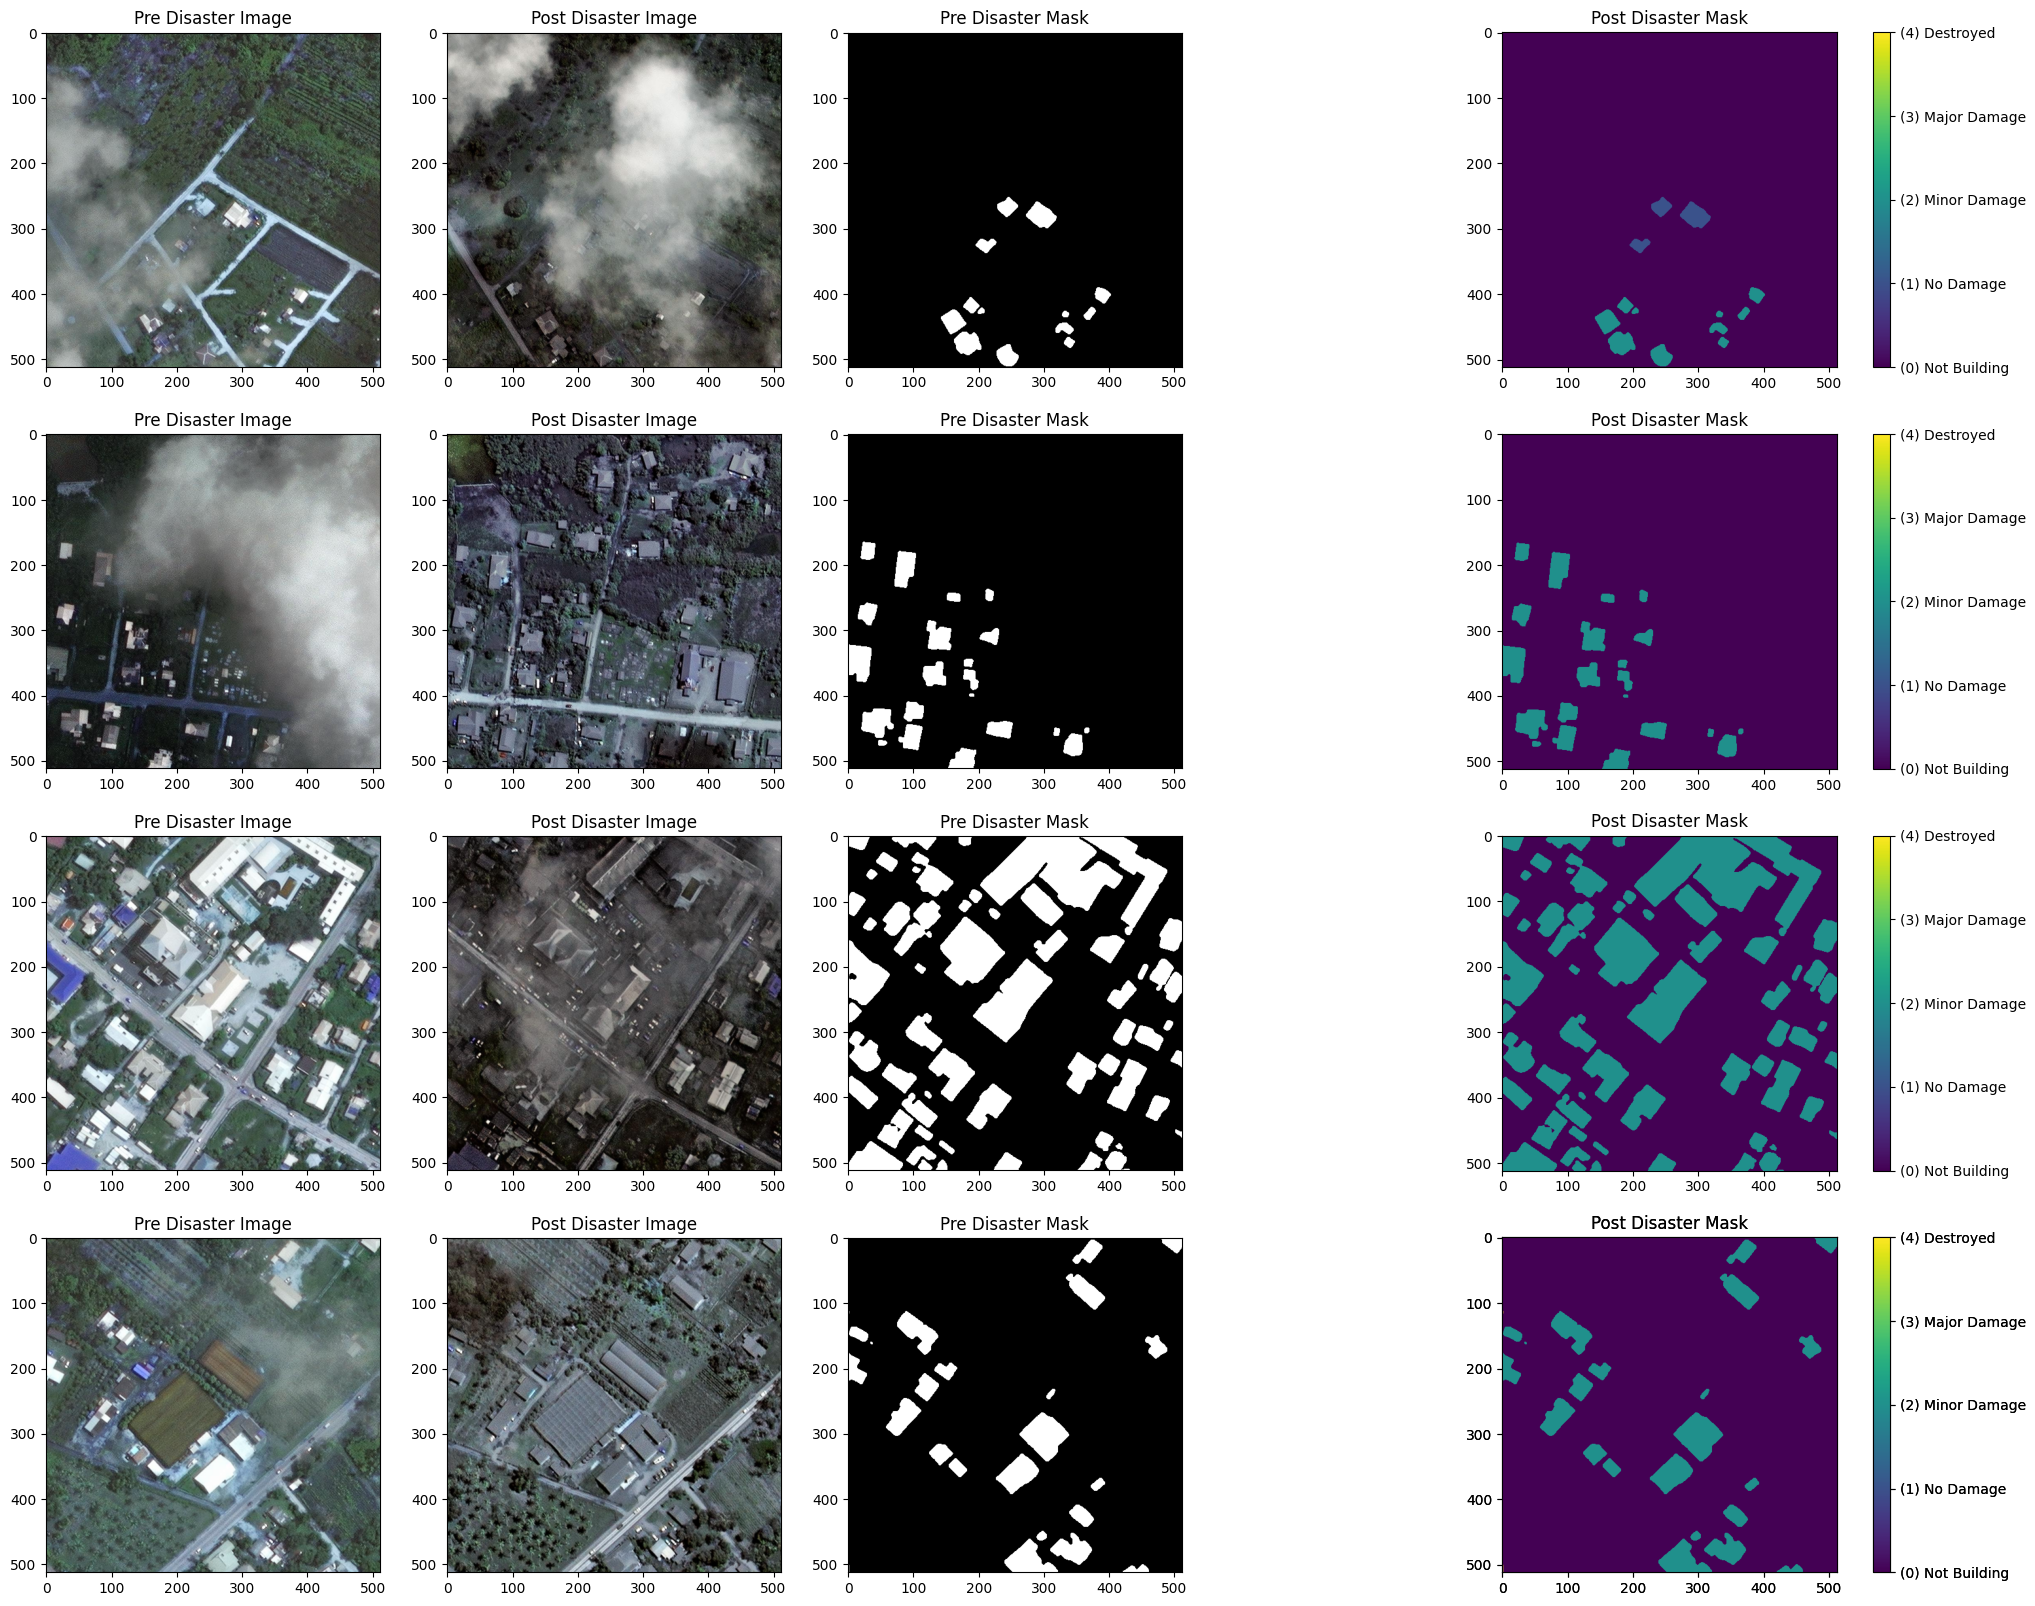

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


num_rows = 4
num_cols = 4 + 1

target_level = 4
found_target_level = False

current_row = 0
plt.figure(figsize=(5 * num_cols, 5 * num_rows))
for i, data in enumerate(all_data):

    post_target = cv2.imread(data.post_target, cv2.IMREAD_GRAYSCALE)
    if post_target.max() <= 1:
        continue

    if current_row >= num_rows: # row condition is met.
        if found_target_level: # if target level condition is also met, exit.
            break
        elif target_level in np.unique(post_target): # otherwise, if target level condition is to be met in this iteration, continue in normal flow.
            pass
        else: # otherwise, continue (skip) until target level condition is met. 
            continue

    base_idx = num_cols * min(current_row, num_rows-1)
    print(f"Row {current_row}: data {i} ({data.stem})", end=" | ")

    pre_img = cv2.imread(data.pre_img)
    plt.subplot(num_rows, num_cols, base_idx + 1 )
    plt.imshow(pre_img)
    plt.title("Pre Disaster Image")

    post_img = cv2.imread(data.post_img)
    plt.subplot(num_rows, num_cols, base_idx + 2 )
    plt.imshow(post_img)
    plt.title("Post Disaster Image")

    pre_target = cv2.imread(data.pre_target, cv2.IMREAD_GRAYSCALE)
    plt.subplot(num_rows, num_cols, base_idx + 3 )
    plt.imshow(pre_target, cmap="gray")
    plt.title("Pre Disaster Mask")
    print("Pre Disaster Mask Values:", np.unique(pre_target),  end=" | ")

    found_target_level = found_target_level or target_level in np.unique(post_target) # do not set to False if once set to True
    ax = plt.subplot(num_rows, num_cols, (base_idx + 4, base_idx + 5) )
    im = plt.imshow(post_target, vmin=0, vmax=4)
    plt.title("Post Disaster Mask")
    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.set_ticks(list(damage_levels_dict.keys()))
    cbar.set_ticklabels([f"({i}) {damage_levels_dict[i]}" for i in damage_levels_dict.keys()] )
    # cbar.set_label("Damage Levels")
    print("Post Disaster Mask Values:", np.unique(post_target))

    current_row += 1 # increase when a new row is added to the plot. 

plt.show()


## Create Data Lists

In [19]:
from tqdm import tqdm
import os.path

################################################################################################################

print("Warning; create data paths in the previous cells before running this.")

################################################################################################################

def create_combined_list(base_path: str, all_data: list[DataPaths]):
    with open(f"{base_path}/all_list.txt", "w") as f:
        for d in tqdm(all_data):
            f.write(f"{d.stem}\n")
        print(f"Created: {os.path.realpath(f.name)}")

def create_train_test_lists(base_path: str, all_data: list[DataPaths], train_ratio: float):
    TOTAL = len(all_data)
    BORDER_IDX = round(TOTAL * train_ratio)

    with open(f"{base_path}/train_list.txt", "w") as f:
        for i in range(0, BORDER_IDX):
            d = all_data[i]
            f.write(f"{d.stem}\n")
        print(f"Generated: {os.path.realpath(f.name)}")

    with open(f"{base_path}/test_list.txt", "w") as f:
        for i in range(BORDER_IDX, TOTAL):
            d = all_data[i]
            f.write(f"{d.stem}\n")
        print(f"Generated: {os.path.realpath(f.name)}")

################################################################################################################

TRAIN_RATIO = 0.80

create_combined_list(BASE_PATH, all_data)
create_train_test_lists(BASE_PATH, all_data, TRAIN_RATIO)

create_combined_list(FILTERED_BASE_PATH, all_filtered_data)
create_train_test_lists(FILTERED_BASE_PATH, all_filtered_data, TRAIN_RATIO)



Warning; create data paths in the previous cells before running this.


100%|██████████| 434/434 [00:00<00:00, 2190527.00it/s]


Created: /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/tonga-volcano/all_list.txt
Generated: /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/tonga-volcano/train_list.txt
Generated: /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/tonga-volcano/test_list.txt


100%|██████████| 308/308 [00:00<00:00, 5405211.85it/s]

Created: /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/filtered/all_list.txt
Generated: /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/filtered/train_list.txt
Generated: /mnt/storage1/alpgenc/change_detection/datasets/tonga_volcano/filtered/test_list.txt
